# Import

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm

import contextlib
from src.preprocessing import apply_transformation

# Data & PCA factors

In [96]:
# FRED
fred_md = pd.read_csv("data/fred_md_2024_12.csv")
fred_md_short = (
    fred_md.iloc[1:]
    .assign(sasdate=pd.to_datetime(fred_md.iloc[1:].sasdate, format="%m/%d/%Y"))
    .set_index("sasdate")
)
fred_info = pd.read_csv("data/FRED_MD_updated_appendix.csv", encoding="latin1")

start_date, end_date = "1960", "2024"

for _, row in fred_info.iterrows():
    series_name = row['fred']
    transformation_code = row['tcode']

    # Apply appropriate transformation to fred df
    with contextlib.suppress(Exception):
        fred_md_short[series_name] = apply_transformation(fred_md_short[series_name], transformation_code)

fred_md_short = fred_md_short[
    (fred_md_short.index >= start_date) & (fred_md_short.index <= end_date)
].dropna(axis=1)

# RECESSION
us_rec = pd.read_csv("data/USREC.csv")
us_rec = us_rec.assign(
    observation_date=pd.to_datetime(us_rec.observation_date)
    ).set_index("observation_date")
us_rec = us_rec.loc[fred_md_short.index,:]

# PCA
pca_60 = pd.read_csv('data/PCA/pca_60.csv')
pca_80 = pd.read_csv('data/PCA/pca_80.csv')
pca_90 = pd.read_csv('data/PCA/pca_90.csv')

pca_60 = pca_60.assign(sasdate=pd.to_datetime(pca_60.sasdate)).set_index("sasdate")
pca_80 = pca_80.assign(sasdate=pd.to_datetime(pca_80.sasdate)).set_index("sasdate")
pca_90 = pca_90.assign(sasdate=pd.to_datetime(pca_90.sasdate)).set_index("sasdate")

# Model Estimation

In [97]:
pca_60_lagged = pca_60.shift(1).dropna()
pca_80_lagged = pca_80.shift(1).dropna()
pca_90_lagged = pca_90.shift(1).dropna()

common_index = pca_60_lagged.index.intersection(us_rec.index)
y = us_rec.loc[common_index]

# 1. PCA 60

In [98]:
X_train, X_test, y_train, y_test = train_test_split(pca_60_lagged, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit_model = LogisticRegression(solver='liblinear', class_weight='balanced', penalty='l1', max_iter=1000)
logit_model.fit(X_train_scaled, y_train.values.ravel())


LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='liblinear')

In [99]:
coefficients = logit_model.coef_[0]
selected_pca_features = np.where(coefficients != 0)[0]
print("Selected PCA components:", selected_pca_features)

Selected PCA components: [ 0  1  2  3  4  5  6  7  8  9 10 11]


## Results

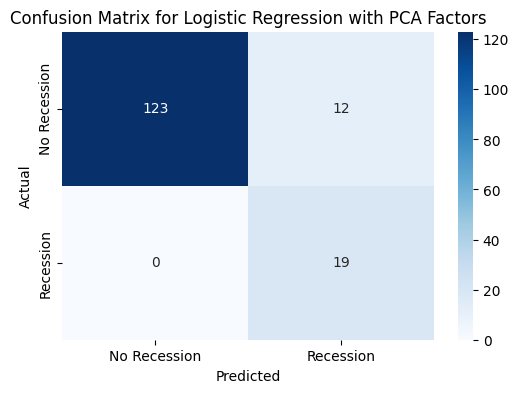

Logit PCA 60:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95       135
           1       0.61      1.00      0.76        19

    accuracy                           0.92       154
   macro avg       0.81      0.96      0.86       154
weighted avg       0.95      0.92      0.93       154



In [100]:
y_pred = logit_model.predict(X_test_scaled)


# Confusion matrix
plt.figure(figsize=(6, 4))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Recession", "Recession"], yticklabels=["No Recession", "Recession"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Logistic Regression with PCA Factors")
plt.show()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
print("Logit PCA 60:\n", classification_report(y_test, y_pred))

# 2. PCA 80

In [101]:
X_train, X_test, y_train, y_test = train_test_split(pca_80_lagged, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit_model = LogisticRegression(solver='liblinear', max_iter=1000, penalty='l1', class_weight='balanced')
logit_model.fit(X_train_scaled, y_train.values.ravel())

coefficients = logit_model.coef_[0]
selected_pca_features = np.where(coefficients != 0)[0]
print("Number of selected PCA components:", len(selected_pca_features))

Number of selected PCA components: 28


## Results

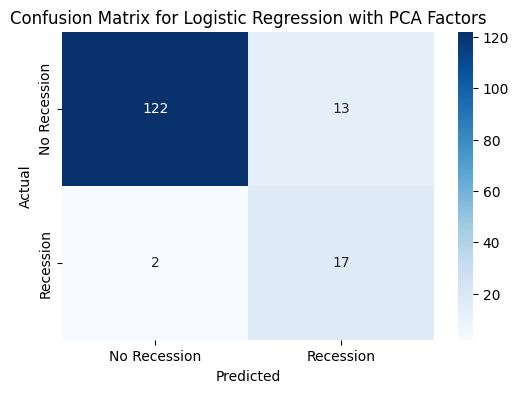

Logit PCA 80:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94       135
           1       0.57      0.89      0.69        19

    accuracy                           0.90       154
   macro avg       0.78      0.90      0.82       154
weighted avg       0.93      0.90      0.91       154



In [102]:
y_pred = logit_model.predict(X_test_scaled)


# Confusion matrix
plt.figure(figsize=(6, 4))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Recession", "Recession"], yticklabels=["No Recession", "Recession"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Logistic Regression with PCA Factors")
plt.show()

# Metrics
print("Logit PCA 80:\n", classification_report(y_test, y_pred))

# 3. PCA 90

In [103]:
X_train, X_test, y_train, y_test = train_test_split(pca_90_lagged, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit_model = LogisticRegression(solver='liblinear', class_weight='balanced', penalty='l1', max_iter=1000)
logit_model.fit(X_train_scaled, y_train.values.ravel())

coefficients = logit_model.coef_[0]
selected_pca_features = np.where(coefficients != 0)[0]
print("Number of selected PCA components:", len(selected_pca_features))


Number of selected PCA components: 42


## Results

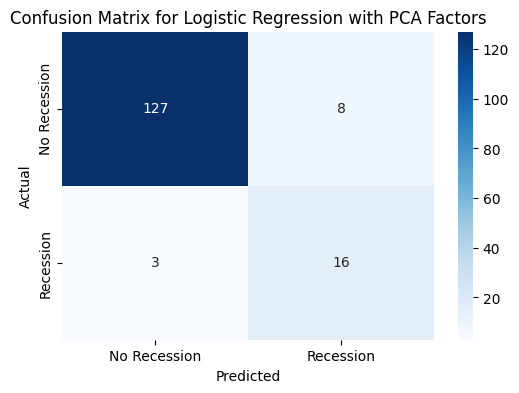

Logit PCA 90:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       135
           1       0.67      0.84      0.74        19

    accuracy                           0.93       154
   macro avg       0.82      0.89      0.85       154
weighted avg       0.94      0.93      0.93       154



In [104]:
y_pred = logit_model.predict(X_test_scaled)


# Confusion matrix
plt.figure(figsize=(6, 4))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Recession", "Recession"], yticklabels=["No Recession", "Recession"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Logistic Regression with PCA Factors")
plt.show()

# Metrics
print("Logit PCA 90:\n", classification_report(y_test, y_pred))